# Stage B Results (Baseline)
This notebook reports results for **Stage B baseline prediction** (window-level EEG feature prediction from lagged features).

**It does not run the pipeline.**  
Run these scripts first from repo root:

1. `python data_index.py`
2. `python stageB_build_panel.py`
3. `python stageB_predict_varx.py`

Then open this notebook to visualize:
- matching coverage (raw ↔ vMF ↔ labels)
- prediction performance metrics (RMSE, R²)
- diagnostics and sanity checks


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths (relative to notebooks/ directory)
REPO_ROOT = Path("..")
OUTPUTS = REPO_ROOT / "outputs"

DATA_INDEX = OUTPUTS / "data_index.csv"
STAGEB_METRICS = OUTPUTS / "stageB_metrics.csv"
STAGEB_PREDS = OUTPUTS / "stageB_pred_samples.csv"
STAGEB_INFO = OUTPUTS / "stageB_model_info.json"

print("Repo root:", REPO_ROOT.resolve())
print("Outputs dir:", OUTPUTS.resolve())


Repo root: D:\Programming\EEG-Research
Outputs dir: D:\Programming\EEG-Research\outputs


In [2]:
# Load index (may or may not exist depending on whether you've run data_index.py)
df_index = None
if DATA_INDEX.exists():
    df_index = pd.read_csv(DATA_INDEX)
    print("Loaded:", DATA_INDEX)
else:
    print("[WARN] Missing:", DATA_INDEX, "(run: python data_index.py)")

# Load Stage B metrics (required)
if not STAGEB_METRICS.exists():
    raise FileNotFoundError(f"Missing {STAGEB_METRICS}. Run: python stageB_predict_varx.py")

df_m = pd.read_csv(STAGEB_METRICS)
print("Loaded:", STAGEB_METRICS)

# Load prediction samples (optional but recommended)
df_p = None
if STAGEB_PREDS.exists():
    df_p = pd.read_csv(STAGEB_PREDS)
    print("Loaded:", STAGEB_PREDS)
else:
    print("[WARN] Missing:", STAGEB_PREDS, "(stageB_predict_varx.py should create it)")
    
df_m.head()


Loaded: ..\outputs\data_index.csv
Loaded: ..\outputs\stageB_metrics.csv
Loaded: ..\outputs\stageB_pred_samples.csv


,unit,rmse,mse,r2,n_test,d,alpha,train_frac
0,0,2.005696e-09,4.022817e-18,0.000000,200,160,10.0,0.7
1,1,1.294092e-08,1.674675e-16,-2.028093,137,160,10.0,0.7
2,2,1.056002e-09,1.115141e-18,0.000000,191,160,10.0,0.7
3,3,4.286354e-10,1.837283e-19,0.000000,238,160,10.0,0.7
4,4,7.229048e-10,5.225914e-19,0.000000,200,160,10.0,0.7


In [3]:
if df_index is None:
    print("No data_index.csv available. Skipping coverage checks.")
else:
    display(df_index.head())
    print("\nMatch status counts:")
    display(df_index["match_status"].value_counts(dropna=False))

    # Simple “match rate”
    match_rate = (df_index["match_status"] == "ok").mean()
    print(f"\nFully matched rate (ok): {match_rate:.2%}")


,subject,task,raw_file,vmf_file,match_status,p_factor,attention,internalizing,externalizing
0,NDARAA306NT2,DespicableMe,sub-NDARAA306NT2_DespicableMe_raw.npy,sub-NDARAA306NT2_DespicableMe_probabilities.npz,ok,0.987,-0.647,1.240,-1.051
1,NDARAA306NT2,DiaryOfAWimpyKid,sub-NDARAA306NT2_DiaryOfAWimpyKid_raw.npy,sub-NDARAA306NT2_DiaryOfAWimpyKid_probabilitie...,ok,0.987,-0.647,1.240,-1.051
2,NDARAA306NT2,FunwithFractals,sub-NDARAA306NT2_FunwithFractals_raw.npy,sub-NDARAA306NT2_FunwithFractals_probabilities...,ok,0.987,-0.647,1.240,-1.051
3,NDARAA306NT2,ThePresent,sub-NDARAA306NT2_ThePresent_raw.npy,sub-NDARAA306NT2_ThePresent_probabilities.npz,ok,0.987,-0.647,1.240,-1.051
4,NDARAA504CRN,DespicableMe,sub-NDARAA504CRN_DespicableMe_raw.npy,sub-NDARAA504CRN_DespicableMe_probabilities.npz,ok,-0.392,-0.342,0.643,0.442



Match status counts:


match_status
ok    302
Name: count, dtype: int64


Fully matched rate (ok): 100.00%


In [4]:
print("Stage B metrics columns:", list(df_m.columns))
display(df_m.describe(include="all"))


Stage B metrics columns: ['unit', 'rmse', 'mse', 'r2', 'n_test', 'd', 'alpha', 'train_frac']


,unit,rmse,mse,r2,n_test,d,alpha,train_frac
count,302.000000,3.020000e+02,3.020000e+02,302.000000,302.000000,302.0,302.0,3.020000e+02
mean,150.500000,1.876554e-06,1.429164e-10,-148.401739,217.874172,160.0,10.0,7.000000e-01
std,87.324109,1.182616e-05,1.436909e-09,1809.944077,60.114100,0.0,0.0,1.112066e-16
min,0.000000,1.336872e-14,1.787227e-28,-26730.889236,137.000000,160.0,10.0,7.000000e-01
25%,75.250000,5.678418e-10,3.224446e-19,0.000000,191.000000,160.0,10.0,7.000000e-01
50%,150.500000,1.140125e-09,1.299887e-18,0.000000,200.000000,160.0,10.0,7.000000e-01
75%,225.750000,3.175370e-09,1.008362e-17,0.000000,238.000000,160.0,10.0,7.000000e-01
max,301.000000,1.333931e-04,1.779371e-08,0.631919,316.000000,160.0,10.0,7.000000e-01


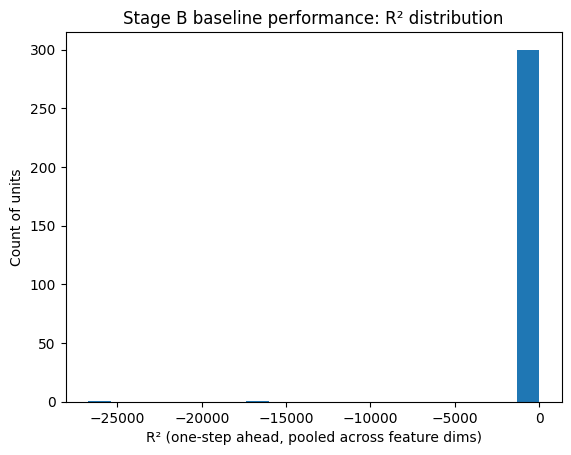

In [5]:
plt.figure()
plt.hist(df_m["r2"].dropna(), bins=20)
plt.xlabel("R² (one-step ahead, pooled across feature dims)")
plt.ylabel("Count of units")
plt.title("Stage B baseline performance: R² distribution")
plt.show()


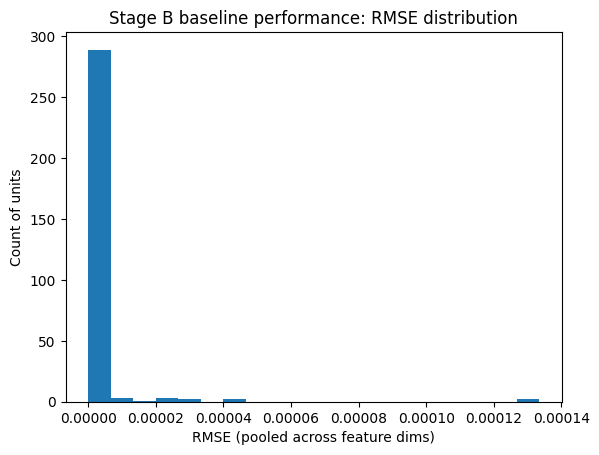

In [6]:
plt.figure()
plt.hist(df_m["rmse"].dropna(), bins=20)
plt.xlabel("RMSE (pooled across feature dims)")
plt.ylabel("Count of units")
plt.title("Stage B baseline performance: RMSE distribution")
plt.show()


In [7]:
df_sorted = df_m.sort_values("r2", ascending=False).reset_index(drop=True)

print("Top 10 units by R²:")
display(df_sorted.head(10))

print("Bottom 10 units by R²:")
display(df_sorted.tail(10))


Top 10 units by R²:


,unit,rmse,mse,r2,n_test,d,alpha,train_frac
0,48,2.060356e-07,4.245067e-14,0.631919,200,160,10.0,0.7
1,298,1.511913e-06,2.285881e-12,0.413339,137,160,10.0,0.7
2,52,8.133598e-09,6.615542e-17,0.326486,238,160,10.0,0.7
3,61,3.073679e-07,9.447503e-14,0.279907,316,160,10.0,0.7
4,141,8.846325e-09,7.825747e-17,0.276554,316,160,10.0,0.7
5,296,2.233371e-05,4.987947e-10,0.171865,238,160,10.0,0.7
6,226,3.736528e-08,1.396164e-15,0.143624,191,160,10.0,0.7
7,295,9.682435e-07,9.374955e-13,0.117856,316,160,10.0,0.7
8,79,1.069515e-08,1.143863e-16,0.107815,191,160,10.0,0.7
9,4,7.229048e-10,5.225914e-19,0.000000,200,160,10.0,0.7


Bottom 10 units by R²:


,unit,rmse,mse,r2,n_test,d,alpha,train_frac
292,118,1.046491e-06,1.095144e-12,-12.031376,200,160,10.0,0.7
293,174,4.113811e-08,1.692344e-15,-29.100147,316,160,10.0,0.7
294,294,5.457685e-08,2.978633e-15,-36.990968,191,160,10.0,0.7
295,60,9.343059e-08,8.729275e-15,-44.552053,191,160,10.0,0.7
296,125,1.757835e-07,3.089985e-14,-49.866806,191,160,10.0,0.7
297,129,2.049824e-05,4.201778e-10,-188.195990,137,160,10.0,0.7
298,23,2.514583e-05,6.323126e-10,-331.228887,238,160,10.0,0.7
299,249,3.106072e-05,9.647682e-10,-626.199030,238,160,10.0,0.7
300,46,2.968853e-06,8.814090e-12,-16661.657121,316,160,10.0,0.7
301,178,1.424566e-06,2.029388e-12,-26730.889236,316,160,10.0,0.7


In [8]:
if df_index is None:
    print("No data_index.csv, so cannot map unit IDs to subject/task.")
else:
    # This is a weak mapping unless you guarantee unit ordering matches raw file ordering.
    # For now, we show the raw file list to help you manually connect.
    print("Index rows:", len(df_index))
    display(df_index[["subject","task","raw_file","vmf_file","match_status"]].head(15))


Index rows: 302


,subject,task,raw_file,vmf_file,match_status
0,NDARAA306NT2,DespicableMe,sub-NDARAA306NT2_DespicableMe_raw.npy,sub-NDARAA306NT2_DespicableMe_probabilities.npz,ok
1,NDARAA306NT2,DiaryOfAWimpyKid,sub-NDARAA306NT2_DiaryOfAWimpyKid_raw.npy,sub-NDARAA306NT2_DiaryOfAWimpyKid_probabilitie...,ok
2,NDARAA306NT2,FunwithFractals,sub-NDARAA306NT2_FunwithFractals_raw.npy,sub-NDARAA306NT2_FunwithFractals_probabilities...,ok
3,NDARAA306NT2,ThePresent,sub-NDARAA306NT2_ThePresent_raw.npy,sub-NDARAA306NT2_ThePresent_probabilities.npz,ok
4,NDARAA504CRN,DespicableMe,sub-NDARAA504CRN_DespicableMe_raw.npy,sub-NDARAA504CRN_DespicableMe_probabilities.npz,ok
5,NDARAA504CRN,DiaryOfAWimpyKid,sub-NDARAA504CRN_DiaryOfAWimpyKid_raw.npy,sub-NDARAA504CRN_DiaryOfAWimpyKid_probabilitie...,ok
6,NDARAA504CRN,FunwithFractals,sub-NDARAA504CRN_FunwithFractals_raw.npy,sub-NDARAA504CRN_FunwithFractals_probabilities...,ok
7,NDARAA504CRN,ThePresent,sub-NDARAA504CRN_ThePresent_raw.npy,sub-NDARAA504CRN_ThePresent_probabilities.npz,ok
8,NDARAA947ZG5,RestingState,sub-NDARAA947ZG5_RestingState_raw.npy,sub-NDARAA947ZG5_RestingState_probabilities.npz,ok
9,NDARAA948VFH,DespicableMe,sub-NDARAA948VFH_DespicableMe_raw.npy,sub-NDARAA948VFH_DespicableMe_probabilities.npz,ok


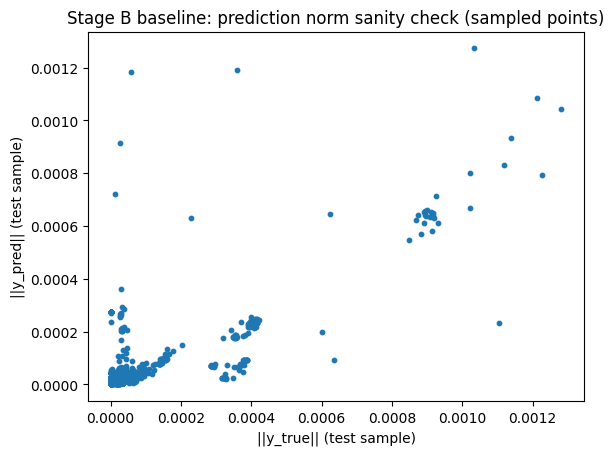

In [9]:
if df_p is None:
    print("No stageB_pred_samples.csv available.")
else:
    plt.figure()
    plt.scatter(df_p["ytrue_norm"], df_p["yhat_norm"], s=10)
    plt.xlabel("||y_true|| (test sample)")
    plt.ylabel("||y_pred|| (test sample)")
    plt.title("Stage B baseline: prediction norm sanity check (sampled points)")
    plt.show()


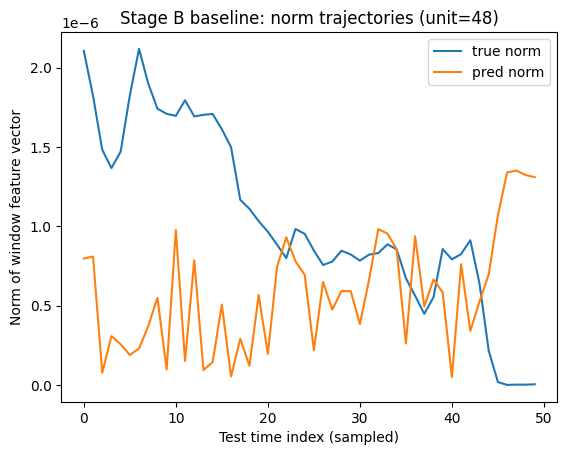

In [10]:
if df_p is None:
    print("No prediction samples available.")
else:
    # Pick best unit by R²
    best_unit = int(df_sorted.iloc[0]["unit"])
    sub = df_p[df_p["unit"] == best_unit].copy()
    
    plt.figure()
    plt.plot(sub["t_test_index"], sub["ytrue_norm"], label="true norm")
    plt.plot(sub["t_test_index"], sub["yhat_norm"], label="pred norm")
    plt.xlabel("Test time index (sampled)")
    plt.ylabel("Norm of window feature vector")
    plt.title(f"Stage B baseline: norm trajectories (unit={best_unit})")
    plt.legend()
    plt.show()


## Interpretation checklist (Stage B baseline)

**What this baseline is doing**
- It predicts window-level EEG feature vectors from **one lag** of window-level EEG feature vectors.
- This is a “VAR(1)-style” baseline with ridge shrinkage.

**What success looks like**
- R² distribution clearly above 0 for some units (not all).
- Predicted norms track true norms reasonably.
- Best units often correspond to cleaner recordings or stable tasks.

**What to improve next**
- Align vMF time steps exactly to EEG windows (replace any resampling).
- Add vMF covariates to make a VARX baseline:
  \[
  y_{it} = A y_{i,t-1} + B Z_{it} + e_{it}
  \]
- Add multi-lag (VAR(p)) and compare performance.
- Add subject/task stratification and pooled estimation across units.
